# Introduction
<a id="0"></a>

<p>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).</p>

<h3> Objective </h3>
<p>To build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. </p>

<h3> Steps for word tokenization</h3> 

1. [Identify URL in the test and remove it](#1)
2. [Remove all punctuation](#2)
3. [Remove stop words (the, a, an, in, ...)](#3)
4. [Count unique words (collections)](#4)
5. [Splitting training and validation set](#5)
6. [Create word index](#6)
7. [Replacing text into series of number](#7)
8. [Make every sentences/ text same length](#8)
9. [Reversing keys values in word index dict, for decoding later](#9)

<h3> Model training </h3> 

10. [Create LSTM model](#10)
<h5>Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. LSTMs are famous in text and time series based problems because they are not only feedforward networks. They can retain past memory in their networks which is known as back propagation.</h5>
<h6>LSTM can have multiple hidden layers and as it passes through every layer, the relevant information is kept and all the irrelevant information gets discarded in every single cell. </h6>
<hr/>
<img src='https://d2l.ai/_images/lstm-0.svg'/>
<h5>LSTM has 3 main gates.</h5>
<h6>1. FORGET Gate</h6>
- This gate is responsible for deciding which information is kept for calculating the cell state and which is not relevant and can be discarded.
<h6>2. INPUT Gate</h6>
- Input Gate updates the cell state and decides which information is important and which is not. As forget gate helps to discard the information, the input gate helps to find out important information and store certain data in the memory that relevant.
<h6>3. OUTPUT Gate</h6>
-The last gate which is the Output gate decides what the next hidden state should be

<p>Tradition neural networks suffer from <strong>short-term memory</strong>. Also, a big drawback is the vanishing gradient problem. ( While backpropagation the gradient becomes so small that it tends to 0 and such a neuron is of no use in further processing.) LSTMs efficiently improves performance by <strong>memorizing the relevant information </strong>that is important and finds the pattern.</p>



<br/>

11. [Naive Bayes Classifiers](#11)
<h5>The Naive Bayes classifier is a simple classifier that classifies based on probabilities of events. It is the applied commonly to text classification.</h5>
<h5>Bayes' Theorem</h5><img src='https://miro.medium.com/max/358/1*8vBP06EtIIf-420o_q1u6g.png' width='300'/>
<p>So can we determined the probability <strong> P(disaster post|Is this a disaster post)</strong> and <strong> P(non-disaster post|Is this a disaster post)</strong>, and comparing which has a higher probability.</p>
<p> Check <a href='https://medium.com/analytics-vidhya/naive-bayes-classifier-for-text-classification-556fabaf252b#:~:text=The%20Naive%20Bayes%20classifier%20is%20a%20simple%20classifier,include%20less%20training%20time%20and%20less%20training%20data.'>here</a> for detail of how Naive Bayes work using Bayes' Theorem and sentence spliting to word</p>


<h3> Sample text and model testing </h3>

[Click here to see more](#12)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
# Tokenize
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# create LSTM model
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
path = '/Users/Asus/Desktop/Unity Game/python/Data_Analysis/Text_Classification/dataset'

train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

## First glance of data

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<strong>Note:</strong>
<ol>
    <li>text: Twitter texts </li>
    <li>target: 1 mean disaster text, 0 mean non-disaster text</li>
</ol>

In [50]:
print('first 10 sample twitter texts (original):')
[(idx, txt) for idx, txt in enumerate(train.text.to_numpy()[:10])]

first 10 sample twitter texts (original):


[(0, 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'),
 (1, 'Forest fire near La Ronge Sask. Canada'),
 (2,
  "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"),
 (3, '13,000 people receive #wildfires evacuation orders in California '),
 (4,
  'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '),
 (5,
  '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'),
 (6,
  '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'),
 (7, "I'm on top of the hill and I can see a fire in the woods..."),
 (8,
  "There's an emergency evacuation happening now in the building across the street"),
 (9, "I'm afraid that the tornado is coming to our area...")]

In [5]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


## Data shape

In [6]:
print(f'Shape of train data: {train.shape},\nShape of test data: {test.shape}')

Shape of train data: (7613, 5),
Shape of test data: (3263, 4)


## Missing data

In [7]:
print('Missing value count:')
train.isnull().sum()

Missing value count:


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Target distribution ratio
- to see evenness of our target data. Is dataset container equal amount of disaster post and non-disaster post?

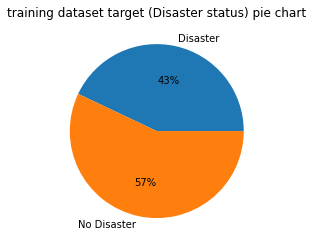

In [8]:
target_class = {'Disaster' :(train.target == 1).sum(), 'No Disaster': (train.target == 0).sum()}
plt.pie(data = target_class, labels=target_class.keys(), x=target_class.values(), autopct='%.0f%%')
plt.title('training dataset target (Disaster status) pie chart')
plt.show()

## Text data preprocessing
- Normal text contain redundant words, punctuation and url which are not helpful in text classification.

In [9]:
print('Original text before preprocessing:')
train.text.to_numpy()

Original text before preprocessing:


array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

<a id="1"></a>
### - Identify URL in the test and remove it
- we can not get much information from url to identify the disaster posts, so we remove it.

[Back to top](#0)

In [10]:
print('Original text with URL (first 5 text):')
[txt for txt in train.text if 'http:' in txt or 'www.' in txt][:5]

Original text with URL (first 5 text):


['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA']

In [11]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# for train dataset
train['text_cleaned'] = train.text.apply(lambda x: remove_url(x))
# for test dataset
test['text_cleaned'] = test.text.apply(lambda x: remove_url(x))

print('All the URL link has been removed')
[txt for txt in train.text_cleaned if 'http:' in txt or 'www.' in txt][:]

All the URL link has been removed


[]

<a id="2"></a>

### - Remove all punctuation
- Punctuation does not bring impact to our analysis either, so we remove it using string.punctuation.

[Back to top](#0)

In [12]:
# train dataset
train['text_cleaned'] = train.text_cleaned.apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
# test dataset
test['text_cleaned'] = test.text_cleaned.apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
train['text_cleaned'].to_numpy()

array(['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask Canada',
       'All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected',
       ..., 'M194 0104 UTC5km S of Volcano Hawaii ',
       'Police investigating after an ebike collided with a car in Little Portugal Ebike rider suffered serious nonlife threatening injuries',
       'The Latest More Homes Razed by Northern California Wildfire  ABC News '],
      dtype=object)

<a id="3"></a>
### - Remove stop words (<i>the</i>, <i>a</i>, <i>an</i>, <i>in</i>, ...)
- The stop words is a redundant words which does not bring significant meaning to the message, so we remove it.

[Back to top](#0)

In [13]:
#  get all the stop words
stop = set(stopwords.words('english'))
# remove it
train['text_cleaned'] = train.text_cleaned.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop]))
test['text_cleaned'] = test.text_cleaned.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop]))
train['text_cleaned'].to_numpy()

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'm194 0104 utc5km volcano hawaii',
       'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries',
       'latest homes razed northern california wildfire abc news'],
      dtype=object)

<a id="4"></a>
### - Count unique words
- We want to know how many words and how frequent the word occured in our data

[Back to top](#0)

<p> Using Counter from collection to count unique word</p>

In [14]:
def count_word(text):
    count = Counter()
    for txt in text:
        for word in txt.split():
            # save word and put in dict
            count[word] +=1
    return count
        
counter_train = count_word(train.text_cleaned)
counter_test = count_word(test.text_cleaned)
num_unique_word = len(counter_train)

print(f'Total number of words : {num_unique_word}')
print(f'Most common words found: {counter_train.most_common(5)}')

Total number of words : 17971
Most common words found: [('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]


<a id="5"></a>
## Splitting training and validation set
- We seperate the data to training and validation set. Training data will feed inside model and train. When model is fully trained by train data, we then feed in validation data to test the modal accuracy. 


[Back to top](#0)

In [15]:
#  int to round off
train_size = int(train.shape[0] * 0.8)

# convert to numpy array
X_train = train.text_cleaned[:train_size].to_numpy()
y_train = train.target[:train_size].to_numpy()
X_valid = train.text_cleaned[train_size:].to_numpy()
y_valid = train.target[train_size:].to_numpy()
test_data = test.text_cleaned.to_numpy()

print(f'Training set shape: {len(X_train)}\nValidation set shape: {len(X_valid)}')

Training set shape: 6090
Validation set shape: 1523


<a id="6"></a>
## Vectorize a text corpus (truning text into sequence of integers)
- Machine learning model only take number as input, so we convert text into number. Since we know how many word in our dataset (unique word), we can assign number to each text using tokenizer library.

 [Back to top](#0)

In [16]:
tokenizer = Tokenizer(num_words=num_unique_word)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print(f'total word index: {len(word_index)}\n')
print('Word index dict: (show only first 20 words)')
for idx, (k, v) in enumerate(word_index.items()):
    if idx == 20:
        break
    print(k, v)

total word index: 15470

Word index dict: (show only first 20 words)
like 1
amp 2
fire 3
im 4
get 5
via 6
new 7
people 8
news 9
dont 10
emergency 11
one 12
2 13
us 14
video 15
disaster 16
burning 17
body 18
would 19
buildings 20


<a id="7"></a>
### - replacing text into series of number
[Back to top](#0)

In [17]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences = tokenizer.texts_to_sequences(test_data)

X_train_sequences[:5]

[[3739, 696, 235, 41, 1282, 3740, 14],
 [71, 3, 129, 576, 5670, 5671, 1283],
 [1448, 1186, 1882, 495, 5672, 1449, 116, 1882, 495, 976, 1187],
 [2243, 8, 3741, 1070, 116, 976, 24],
 [27, 1071, 358, 5673, 1635, 892, 1070, 5674, 91]]

In [18]:
train.text_cleaned[:5]

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text_cleaned, dtype: object

<a id="8"></a>
### - Make every sentences/ text same length
- we make every sentence to same length for training purposes

[Back to top](#0)

In [19]:
max_text_len = max([len(txt) for txt in X_train_sequences])

# padding and truncating for numbering position
train_padded = pad_sequences(X_train_sequences, maxlen=max_text_len, padding='post', truncating='post')
valid_padded = pad_sequences(X_valid_sequences, maxlen=max_text_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_text_len, padding='post', truncating='post')

print(f'train_padded shape: {train_padded.shape}\nvalid_padded shape: {valid_padded.shape}')
train_padded[0]

train_padded shape: (6090, 25)
valid_padded shape: (1523, 25)


array([3739,  696,  235,   41, 1282, 3740,   14,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

<a id="9"></a>
### - Reversing keys values in word index dict, for decoding later
[Back to top](#0)

In [20]:
reverse_word_index = dict((val, key) for key, val in word_index.items())

# get in dict: with 2nd parameter, if there is no such seq, return ?
def decode(seq):
    return ' '.join([reverse_word_index.get(s, '?') for s in seq])

<a id="10"></a>
# Create LSTM model
[Back to top](#0)

<a href="https://www.tensorflow.org/text/guide/word_embeddings">Tensorflow Word Embeddings link</a>
<p>Create LSTM< using Tensorflow & Keras</p>

In [21]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_word, 32, input_length=max_text_len))
# Take input as integer matrix of size (batch, input_length)
# Largest integer (word index) in input should not be larger than num_words (vocabulary size)
#  output shape is (batch_dimension, input_length, 32)

# 64 number of output, dropout is 10%
model.add(layers.LSTM(64, dropout=0.1))
#  Dense with 1 output in the end with sigmoid function
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 32)            575072    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________


In [22]:
# from_logits=False as we already specify sigmoid function
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.005)
metrics=['accuracy']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [23]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(valid_padded, y_valid), verbose=2)

Epoch 1/10
191/191 - 6s - loss: 0.6600 - accuracy: 0.6158 - val_loss: 0.6808 - val_accuracy: 0.5594
Epoch 2/10
191/191 - 3s - loss: 0.5800 - accuracy: 0.7102 - val_loss: 0.5989 - val_accuracy: 0.7426
Epoch 3/10
191/191 - 3s - loss: 0.4583 - accuracy: 0.8246 - val_loss: 0.6449 - val_accuracy: 0.7098
Epoch 4/10
191/191 - 3s - loss: 0.4051 - accuracy: 0.8358 - val_loss: 0.5607 - val_accuracy: 0.7406
Epoch 5/10
191/191 - 3s - loss: 0.2681 - accuracy: 0.9095 - val_loss: 0.5504 - val_accuracy: 0.7741
Epoch 6/10
191/191 - 3s - loss: 0.1889 - accuracy: 0.9404 - val_loss: 0.6312 - val_accuracy: 0.7610
Epoch 7/10
191/191 - 3s - loss: 0.1285 - accuracy: 0.9626 - val_loss: 0.6790 - val_accuracy: 0.7682
Epoch 8/10
191/191 - 3s - loss: 0.0925 - accuracy: 0.9726 - val_loss: 0.7416 - val_accuracy: 0.7761
Epoch 9/10
191/191 - 3s - loss: 0.0723 - accuracy: 0.9782 - val_loss: 0.7908 - val_accuracy: 0.7485
Epoch 10/10
191/191 - 3s - loss: 0.0614 - accuracy: 0.9795 - val_loss: 0.8011 - val_accuracy: 0.7748

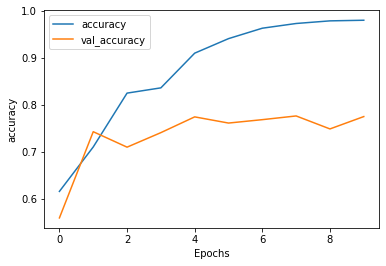

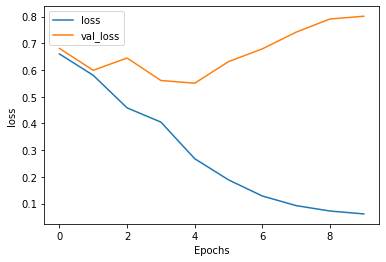

In [24]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

## Confusion matrix
<p>A table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives. This allows more detailed analysis than mere proportion of correct classifications (accuracy).<p>

- calculate Accuracy, percision and sensitivity(recall)
<img src='https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg' width='800'/>

- calculate F1 score
<img src='https://www.researchgate.net/profile/Stephan_Spiegel/publication/327982563/figure/download/fig1/AS:676888573931525@1538394220830/Confusion-matrix-illustrating-the-calculation-of-precision-recall-and-F1-score.png' width='1000'/>

F1 score: 0.75
Accuracy score: 0.77


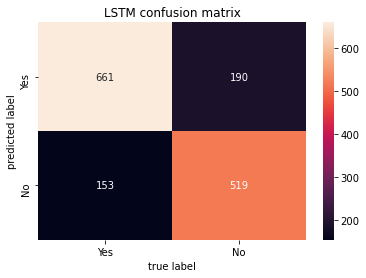

In [25]:
val_pred = model.predict(valid_padded)
val_out = [1 if p > 0.5 else 0 for p in val_pred]
cm = confusion_matrix(y_valid, val_out)
sns.heatmap(cm.T, annot=True, fmt='d', xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
plt.title('LSTM confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')

print(f'F1 score: {f1_score(y_valid, val_out):.2f}')
print(f'Accuracy score: {accuracy_score(y_valid, val_out):.2f}')

In [26]:
prediction = model.predict(test_padded)
# round off to 0 or 1
result =[1 if p > 0.5 else 0 for p in prediction]

In [27]:
for txt, target in zip(test.text[:10], result[:10]):
    print(txt, f'. post: {"non-disaster" if target == 0 else "disaster"}')

Just happened a terrible car crash . post: non-disaster
Heard about #earthquake is different cities, stay safe everyone. . post: non-disaster
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all . post: disaster
Apocalypse lighting. #Spokane #wildfires . post: disaster
Typhoon Soudelor kills 28 in China and Taiwan . post: disaster
We're shaking...It's an earthquake . post: disaster
They'd probably still show more life than Arsenal did yesterday, eh? EH? . post: non-disaster
Hey! How are you? . post: non-disaster
What a nice hat? . post: non-disaster
Fuck off! . post: non-disaster


## Submission

In [28]:
submission['target'] = result
submission.to_csv(os.path.join(path, 'first_submission.csv'), index=False)

<a id="11"></a>
# Naive Bayes Classifiers
[Back to top](#0)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [30]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(train.text, train.target, test_size=0.2, random_state=42)

In [31]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(Xtrain, ytrain)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Naive Bayes F1 score: 0.73
Naive Bayes Accuracy score: 0.80


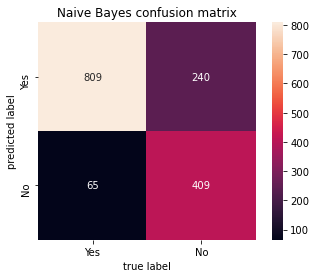

In [32]:
val_nb_pred = nb_model.predict(Xvalid)
nb_cm = confusion_matrix(yvalid, val_nb_pred)
sns.heatmap(nb_cm.T, square=True, annot=True, fmt='d', xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
plt.title('Naive Bayes confusion matrix')
plt.xlabel('true label')
plt.ylabel('predicted label')

# print('Naive Bayes Confusion Matrix:\n', confusion_matrix(yvalid, val_nb_pred))
print(f'Naive Bayes F1 score: {f1_score(yvalid, val_nb_pred):.2f}')
print(f'Naive Bayes Accuracy score: {accuracy_score(yvalid, val_nb_pred):.2f}')

<h5>Observation: As comparison, we can see Naive Bayes has better F1 score and accuracy compare with LSTM</h5>

In [33]:
# test data
nb_result = nb_model.predict(test.text)

In [34]:
test['nb_target'] = ["non-disaster" if nb == 0 else "disaster"for nb in nb_result]
test[['text', 'nb_target']][:15].to_numpy()

array([['Just happened a terrible car crash', 'disaster'],
       ['Heard about #earthquake is different cities, stay safe everyone.',
        'non-disaster'],
       ['there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
        'disaster'],
       ['Apocalypse lighting. #Spokane #wildfires', 'disaster'],
       ['Typhoon Soudelor kills 28 in China and Taiwan', 'disaster'],
       ["We're shaking...It's an earthquake", 'disaster'],
       ["They'd probably still show more life than Arsenal did yesterday, eh? EH?",
        'non-disaster'],
       ['Hey! How are you?', 'non-disaster'],
       ['What a nice hat?', 'non-disaster'],
       ['Fuck off!', 'non-disaster'],
       ["No I don't like cold!", 'non-disaster'],
       ["NOOOOOOOOO! Don't do that!", 'non-disaster'],
       ["No don't tell me that!", 'non-disaster'],
       ['What if?!', 'non-disaster'],
       ['Awesome!', 'non-disaster']], dtype=object)

In [35]:
# submission['target'] = nb_result
# submission.to_csv(os.path.join(path, 'NB_submission_3Oct.csv'), index=False)

<a id="12"></a>
## To predict is my tweet is disaster or not

[back to top](#0)

In [36]:
def text_prediction(txt, model=nb_model):
    pred = model.predict([txt])
    return ['Not disaster post' if txt==0 else 'Disaster post' for txt in pred][0]

In [37]:
text_prediction('I am so sad')

'Not disaster post'

In [38]:
text_prediction('Earthquake happen in KL!!! #scare #panic')

'Disaster post'

In [39]:
text_prediction('The War happen in ...')

'Disaster post'

In [40]:
text_prediction('It kills lots of people!')

'Disaster post'

In [41]:
text_prediction('I wanna break up with you!')

'Not disaster post'

In [42]:
text_prediction('Year end sale! Yay!')

'Not disaster post'

In [43]:
text_prediction('Whole city was destroyed by #sandstorm!')

'Disaster post'